import libraries

In [73]:
import tensorflow as tf  # Only used as a asource of MNIST data
import requests
import numpy as np
import matplotlib.pyplot as plt

Get MNIST data

In [74]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

Select random image from the test part of MNIST

Text(0.5, 1.0, "Digit '8'")

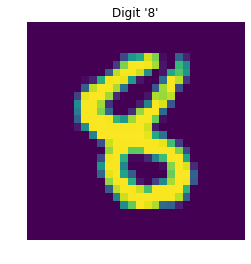

In [75]:
idx = np.random.choice(range(x_test.shape[0]))
x = x_test[idx]
plt.imshow(x)
plt.axis('off')
plt.title(f"Digit '{y_test[idx]}'")

Specify the inference link to the hydrosphere.io

In [76]:
# service_link = "https://dev.k8s.hydrosphere.io/gateway/application/mnist-app"
service_link = "http://fc13d681.serving.odsc.k8s.hydrosphere.io/gateway/application/mnist_app"

Check the inference service

In [77]:
response = requests.post(url=service_link, json={"imgs": [x.tolist()]})
predicted_probas = np.array(response.json()["probabilities"])
f"Predicted label is {predicted_probas.argmax()}"

'Predicted label is 8'

In [80]:
print("Probabilities vector", np.array(response.json()['probabilities']))

Probabilities vector [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


Specify the link to the RISE image interpretability service

In [81]:
rise_link = "http://0.0.0.0:5000/rise" 

In [82]:
rise_config = {"number_of_masks":300,
               "mask_granularity":3,
               "mask_density":0.4,
               "input_size": [28,28],
               "single_channel": True,
               }

In [113]:
response = requests.post(url=rise_link, json={"image": x.tolist(),
                                              "config": rise_config,
                                              "application_name":"mnist_app"})  # Send image in json
print(response)
result_location = response.headers['Location']
print(result_location)

<Response [202]>
http://0.0.0.0:5000/status/rise/f5f45d26-7265-4ec4-95f9-f664ccf8a858


Poll results

In [114]:
# First status
response = requests.get(result_location)
print(response.text)

{
  "state": "PENDING"
}



In [105]:
# Second status with dynamic progress
response = requests.get(result_location)
print(response.text)

{
  "progress": 0.3333333333333333, 
  "state": "STARTED"
}



In [116]:
# Last status with id of mongodb entry
response = requests.get(result_location)
result_id = response.json()['result']
print(response.text)

{
  "result": "5ced20b150e480eeeb62daaf", 
  "state": "SUCCESS"
}



Retrieve results from MongoDB

In [117]:
import pymongo 
client = pymongo.MongoClient()

In [121]:
from bson.objectid import ObjectId
explanation = client['root_cause'].rise_explanations.find_one({"_id":ObjectId(result_id)})

In [123]:
# Examine the keys
explanation.keys()

dict_keys(['_id', 'image', 'config', 'application_name', 'created_at', 'completed_at', 'result'])

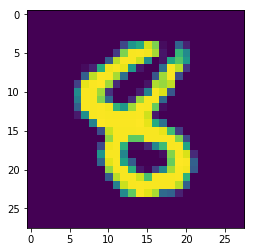

In [127]:
image = np.array(explanation['image'])
plt.imshow(image)

Reconstruct the saliency map tensor from bstring. The result cllection of masks is of shape (number of classes; width; height). It contains a sailency map for each output class.

In [155]:
explanation['result']["masks"][:50].decode("utf-8", 'ignore')

'\x14/݄\x16;~\nݲ; 1O;V\x15;16\x0f;I\x0cB^H;4'

In [132]:
saliency_maps = np.frombuffer(explanation['result']['masks']).reshape(explanation['result']['shape'])
saliency_maps.shape  # For some mystic reason this version of mnist-app produces probabilites vector of 20-dim

(20, 28, 28)

Visualize results

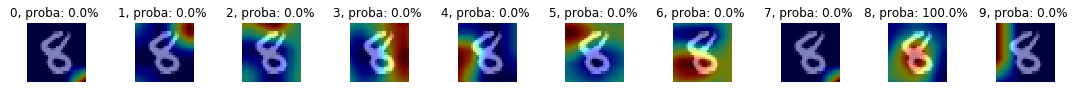

In [141]:
fig, axes = plt.subplots(1, 10)
fig.set_size_inches(15, 6)
for i in range(10):
    axes[i].set_title(f"{i}, proba: {predicted_probas[0][i]*100}% ")
    axes[i].axis('off')
    axes[i].imshow(x, cmap="gray")
    axes[i].imshow(saliency_maps[i], cmap='jet', alpha=0.5)
    
plt.tight_layout()
plt.show()